# Img2brain: Predicting the neural responses to visual stimuli of naturalistic scenes using machine learning

**Author:** [Sebastián Ayala Ruano][myweb]

This notebook is part of my capstone project for the Machine learning course from the [MSc in Systems Biology][sysbio] at [Maastricht University][maasuni].

The goal of this project is to employ machine learning techniques in order to forecast the neural visual responses triggered by naturalistic scenes. These computational models strive to replicate the intricate process through which neuronal activity encodes to visual stimuli aroused by the external environment. The following figure gives an schematic representation of the brain encoding and decoding processes.

<figure>
  <img src="./img/encod_decod_brain.png" alt="my alt text"/>
  <figcaption><strong>Figure 1.</strong> Brain encoding and decoding in fMR. Obtained from <a href="https://doi.org/10.1016/j.eng.2019.03.010">[1]</a>. </figcaption>
</figure>

The encoding models take image pixels as input, transform them into model features, and map these features onto brain activity. This framework enables the prediction of neural responses to images. The following figure illustrates the mapping between the pixel, feature, and brain spaces.

<figure>
  <img src="./img/encod_brain_sp.png" alt="my alt text"/>
  <figcaption><strong>Figure 2.</strong> The general architecture of visual encoding models that consists of three spaces (the input space, the feature space, and the brain activity space) and two in-between mappings. Obtained from <a href="https://doi.org/10.1016/j.neuroimage.2010.07.073">[2]</a>. </figcaption>
</figure>

The data for this project is part of the [Natural Scenes Dataset][nsd] (NSD), a massive dataset of 7T fMRI responses to images of natural scenes coming from the [COCO dataset][coco]. The training dataset consists of brain responses measured at 10000 brain locations (voxels) to 8857 images (in jpg format) for one subject. The 10000 voxels are distributed around the visual pathway and may encode perceptual and semantic features in different proportions. The test dataset comprises 984 images (in jpg format), and the goal is to predict the brain responses to these images. You can access the dataset through Zenodo with the following DOI: [10.5281/zenodo.7979730][dataset_doi]. 

This notebook is divided into the following sections:

0. [Work environment setup](#0-work-environment-setup-and-definition-of-helper-functionsclasses)
1. [Loading data and preprocessing](#1-loading-the-data-and-create-input-and-target-matrices)
2. [Exploratory data analysis](#2-exploratory-data-analysis)
3. [Feature engineering](#3-feature-engineering)
4. [Building and evaluating models](#4-bulding-and-evaluating-machine-learning-models)
5. [Model selection and predictions on the test dataset](#5-model-selection-and-predictions-on-the-test-dataset)
6. [Conclusions and future work](#6-conclusions-and-further-work)

**Credits:** Part of the code for this project was inspired by the [Algonauts Project 2023 Challenge][alg_web] development kit tutorial.

You can find more details about the project in this [GitHub repository][githubrepo].

[nsd]: https://doi.org/10.1038/s41593-021-00962-x
[coco]: https://cocodataset.org/#home
[alg_web]: http://algonauts.csail.mit.edu
[sysbio]: https://www.maastrichtuniversity.nl/education/master/systems-biology
[maasuni]: https://www.maastrichtuniversity.nl/
[myweb]: https://sayalaruano.github.io/
[githubrepo]: https://github.com/sayalaruano/img2brain.git
[dataset_doi]: https://doi.org/10.5281/zenodo.7979730

## 0. Work environment setup and definition of helper functions/classes
Define global variables for the platform (jupyter notebok or colab) and device (cpu or cuda) to be used for the computations. Also, set the working directories, import the libraries and define helper functions/classes.

### 0.1. Define global variables for platform and working directories

If you want to run this notebook locally you should create a conda environment with the required libraries and set the `platform` variable to `local`. You can find the instructions, commands, and the file with the required libraries in the README file of the [GitHub repository][githubrepo].

However, the easiest way to run this notebook is on Google Colab. If you want to run this tutorial on Google Colab, set the `platform` variable to `colab` and you can open it with the following button: [![Open In Colab][colab_badge]][colab_link].

[githubrepo]: https://github.com/sayalaruano/img2brain.git
[colab_badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab_link]: https://colab.research.google.com/github/sayalaruano/img2brain/blob/main/EDA_feateng_modelbuild_img2brain.ipynb

In [1]:
platform = 'jupyter_notebook' #@param ['colab', 'jupyter_notebook'] {allow-input: true}

To run this notebook on Google Colab, you need to upload the data to your Google Drive. The zip file should be called `Data_img2brain.zip` and you can define the path to the data folder in your Google Drive with the `parent_dir`, `data_dir`, and  `zip_file_name` variables. 

On the other hand, if you want to run this notebook locally, you should download the data and define the path to the data folder with the `data_dir` and `zip_file_name` variables.

You can access the dataset through Zenodo with the following DOI: [10.5281/zenodo.7979730][dataset_doi]. 

The data folder should contain the following folders:

1. trainingIMG: contains the training images (8857) in jpg format. The numbering corresponds to the order of the rows in the brain response matrix.
2. testIMG: contains test images (984) in jpg format.
3. trainingfMRI: contains a npy file with the fMRI responses measured at 10000 brain locations (voxels) to the training images. The matrix has 8857 rows (one for each image) and 10000 columns (one for each voxel).

[dataset_doi]: https://doi.org/10.5281/zenodo.7979730

In [ ]:
# Set path for the data with colab
if platform == 'colab':
    parent_dir = 'drive/MyDrive/Maastricht/ML/Project' # Change this variable with your own path
    results_dir = 'Results'
    data_dir = 'Data_img2brain'
    zip_file_name = 'Data_img2brain.zip'

    # connect to drive
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set the path for the data with jupyter notebook
if platform == 'jupyter_notebook':
    data_dir = '../Data_img2brain'
    results_dir = 'Results'
    zip_file_name = '../Data_img2brain.zip'

### 0.2. Imports

In [1]:
# Operative system libraries
import os
import gc
from pathlib import Path
import zipfile
from PIL import Image
from tqdm import tqdm
import pickle

# Data manipulation and EDA
import numpy as np
import pandas as pd

# Plots
from matplotlib import pyplot as plt

# Feature extraction and engineering
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskLasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr as corr

### 0.3. Define global variable for the device
Either if you run this notebook locally or on Google Colab, you can choose to run the computations on the CPU or the GPU. If you want to run the computations on the GPU, set the `device` variable to `cuda`. Otherwise, set it to `cpu`.

In [4]:
device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)

### 0.4. Helper functions and classes
You should run the following cell to define the helper functions and classes that are used in the notebook.

#### 0.4.1. Data loader for images

In [5]:
# Define the preprocessing pipeline for the images to be used in the feature extractor model
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

In [6]:
# Now we define a Dataset class that load, preprocess, and return an image at a time
# that is used after the creation of the indices for the training and test sets
class ImageDataset(Dataset):
    ''' Dataset class for the images to be used in the feature extractor model'''
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

#### 0.4.2. Pretrained DL models and feature extractors for images

In [7]:
# Function to load the pretrained model and print the layer names
def load_pretrained_model(repo_or_dir, model):
    '''
    Loads a pretrained model and prints its layer names.
    :param repo_or_dir: The repository or directory where the model is stored.
    :param model: The model name.
    :return: The loaded model.'''
    
    # Load the model
    model = torch.hub.load(repo_or_dir, model)

    # Send the model to the chosen device ('cpu' or 'cuda')
    model.to(device)

    # Set the model to evaluation mode, since I do not train it, but only use it to extract features
    model.eval()
    # Print the model's layer names
    train_nodes, _ = get_graph_node_names(model)
    print(train_nodes)
    
    return model

In [8]:
# Function to reduce the dimensionality of the feature matrix for the images
def fit_pca(feature_extractor, dataloader, n_features, batch_size):
    '''
    Fits PCA to the features extracted from the pretained models for all images.
    :param feature_extractor: The feature extractor object for a given layer of a pretrained model.
    :param dataloader: The DataLoader object.
    :return: The fitted PCA.'''
    
    # Define PCA parameters
    pca = IncrementalPCA(n_components=n_features, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
        
    return pca

In [9]:
# Function to extract the features from the images using the PCA fitted to the training set
def extract_features(feature_extractor, dataloader, pca):
    '''
    Extracts the features from the images using the PCA fitted to the training set.
    :param feature_extractor: The feature extractor object for a given layer of a pretrained model.
    :param dataloader: The DataLoader object.
    :param pca: The fitted PCA.
    :return: The features extracted from the images using the PCA fitted to the training set.'''
    
    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)

In [10]:
# Function to calculate the correlation coefficients between the predicted and ground truth fMRI data from features extracted 
# from various layers of the pretrained models
def corr_layers(fmri_val_pred, fmri_val, model_layers):
    '''
    Calculates the correlation coefficients between the predicted and ground truth fMRI data from features extracted
    from various layers of the pretrained models.
    :param fmri_val_pred: The predicted fMRI data.
    :param fmri_val: The ground truth fMRI data.
    :param model_layers: The list of the model layers.
    :return: The correlation coefficients between the predicted and ground truth fMRI data from features extracted
    from various layers of the pretrained models.'''
    
    corr_df = pd.DataFrame(columns= model_layers)

    for i, fmri_pred in enumerate(fmri_val_pred):
        # Create a numpy array to store temporally the correlation coefficients between the predicted and ground truth fMRI data for each layer
        corr_fmri_temp = np.zeros(fmri_pred.shape[1])
        for j in tqdm(range(fmri_pred.shape[1])):
            # Correlate each predicted voxel with the corresponding ground truth voxel
            corr_fmri_temp[j] = corr(fmri_pred[:, j], fmri_val[:, j])[0]
            # Append the correlation coefficients to the data frame as a new column for each layer
            corr_df[model_layers[i]] = corr_fmri_temp
    
    return corr_df

#### 0.4.3. Exploratory data analysis

In [22]:
# Define a function to plot the brain activity data of a voxel for all images from a given partition
def plot_voxel_activity(fmri, voxel, partition):
    '''
    Plots the brain activity data of a voxel for all images from a given partition.
    :param fmri: The fMRI data.
    :param voxel: The voxel to plot.
    :param partition: The partition to plot.
    '''
    
    # Plot the brain activity data of the voxel for all images from the partition
    plt.figure(figsize=(16,6))
    plt.xlabel('Image')
    plt.ylabel('Brain activity (BOLD signal)')
    plt.title('Voxel {:d} - {:s} partition'.format(voxel+1, partition))
    plt.plot(fmri[:, voxel]);

In [ ]:
# Define a function to plot the brain activity of a random image for all voxels from a given partition
def plot_image_activity(fmri, img, partition):
    '''
    Plots the brain activity of a random image for all voxels from a given partition.
    :param fmri: The fMRI data.
    :param img: The image to plot.
    :param partition: The partition to plot.
    '''
    
    # Plot the brain activity data of the image for all voxels from the partition
    plt.figure(figsize=(16,6))
    plt.xlabel('Voxel')
    plt.ylabel('Brain activity (BOLD signal)')
    plt.title('Image {:d} - {:s} partition'.format(img+1, partition))
    plt.plot(fmri[img, :]);

In [36]:
# Function to show n random images from the dataset
def show_random_images(data_loader, num_images):
    '''
    Shows n random images from the dataset.
    :param data_loader: The DataLoader object.
    :param num_images: Number of images to show.
    :return: None. It only shows the images.'''
    # Recovers the original `dataset` from the `dataloader`
    dataset = data_loader.dataset
    # Get the number of images and create the random indices
    num_total_images = len(dataset)
    random_indices = np.random.choice(num_total_images, num_images, replace=False)

    # Create subplots and show the images
    plt.figure(figsize=(12, 8))

    # Loop through the indices and create subplots with the images
    for i in range(num_images):
        image = dataset[random_indices[i]]

        # Add the subplot
        plt.subplot(2, num_images // 2, i+1)
        # Show the image with no axis and the index as title
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(f"Image id: {random_indices[i]}")
        plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

#### 0.4.4. Linear models

In [11]:
# Function to calculate the correlation coefficients between the predicted and ground truth fMRI data
def corr_allvoxels(fmri_val_pred, fmri_val):
    '''
    Calculates the correlation coefficients between the predicted and ground truth fMRI data from features extracted
    from various layers of the pretrained models.
    :param fmri_val_pred: The predicted fMRI data.
    :param fmri_val: The ground truth fMRI data.
    :return: The correlation coefficients between the predicted and ground truth fMRI data'''
    
    # Create a numpy array to store temporally the correlation coefficients between the predicted and ground truth fMRI data for each layer
    corr_fmri = np.zeros(fmri_val_pred.shape[1])
    
    for j in tqdm(range(fmri_val_pred.shape[1])):
        # Correlate each predicted voxel with the corresponding ground truth voxel
        corr_fmri[j] = corr(fmri_val_pred[:, j], fmri_val[:, j])[0]
    
    return corr_fmri

In [76]:
# Define a function to plot a histogram of the correlation coefficients
def plot_corr_hist(corr, title, bins=80):
    ''' Plot a histogram of the correlation coefficients.
    :param corr: correlation coefficients
    :param title: title of the plot
    :param bins: number of bins in the histogram
    :return: None. It only shows the plot.
    '''
    plt.figure(figsize=(10, 8))
    plt.hist(corr, bins=bins)
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Number of voxels')
    plt.title(title)
    plt.show()

In [86]:
# Define a functtion to create a dataframe with the top or bottom n voxels and their scores 
# for a given correlation coefficient array
def voxels_df(corr_array, n, top=True):
    ''' Create a dataframe with the top/bottom n voxels and their scores
    :param corr_array: array with correlation coefficients
    :param n: number of top/bottom voxels to select
    :param top: boolean to select top or bottom voxels
    : return: dataframe with the top/bottom n voxels and their scores
    '''
    # Pick the top voxel indexes and their scores
    if top:
        top_voxels = np.argsort(corr_array)[:-(n+1):-1]
    else:
        top_voxels = np.argsort(corr_array)[:(n)]
    top_scores = corr_array[top_voxels]
    
    # Organize the data into a dataframe for better visualization
    df = pd.DataFrame()
    df['voxel'] = top_voxels.astype(int)
    df['score'] = top_scores.round(2)
    df.index += 1
    return df

In [89]:
# Define a function to compare the predicted and actual BOLD signal for a given voxel 
def plot_fmri_pred(voxel, fmri, fmri_pred): 
    '''Plot the predicted and actual BOLD signal for a given voxel
    :param voxel: voxel number
    :param fmri: actual BOLD signal
    :param fmri_pred: predicted BOLD signal
    :return: None
    '''
    plt.figure(figsize=(6,6))
    plt.ylabel('predicted BOLD')
    plt.xlabel('actual BOLD')
    plt.title('Voxel {:d}'.format(voxel))
  
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes
    ]
    # x=y line for reference
    plt.plot(lims, lims, '--', alpha=0.75, zorder=0)
    plt.scatter(fmri[:,voxel], fmri_pred[:,voxel]);

## 1. Loading the data and create input and target matrices

### 1.1. Brain activity data 

The dataset is based on brain surface fMRI data. Every point on the brain surface has activity values expressed in voxels. In this dataset, the brain surface is divided into 10000 vertices (voxels) that are distributed all around the visual pathway. The brain activity data is stored in a numpy array with 8857 rows (one for each image) and 10000 columns (one for each voxel).

In [12]:
# Load brain activity data (fMRI) from zipped npy file
# Check if the files were already extracted
if not os.path.exists(data_dir):
    # Set the path to the zipped file
    zip_file_path = os.path.join(parent_dir, zip_file_name)
    # opening Zip using 'with' keyword in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as file:
        # printing all the information of archive file contents using 'printdir' method
        print(file.printdir())
        # extracting the files using 'extracall' method
        print('Extracting all files...')
        file.extractall()
        print('Done!') # check your directory of zip file to see the extracted files

In [13]:
# Define string with data_dir and the name of the file
fmri_df_path = os.path.join(data_dir, 'trainingfMRI/training.npy')

# Load the data
fmri_df = np.load(fmri_df_path)

# Print shape of data
fmri_df.shape

(8857, 10000)

### 1.2. Stimuli - images 
The training images are stored in the `trainingIMG` folder. The images are in jpg format and the numbering corresponds to the order of the rows in the brain response matrix. The test images are stored in the `testIMG` folder and are also in jpg format.

In [14]:
# Set the paths for the training and test images
train_img_dir  = os.path.join(data_dir, 'trainingIMG')
test_img_dir  = os.path.join(data_dir, 'testIMG')

# Create lists with all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 8857
Test images: 984


### 1.3. Split the training data into training and validation partitions

Create the indices to randomly split the training data into a training (80% of the data) and validation (20% of the data) partition. I set the random seed (`rand_seed` variable) to 224 to ensure reproducibility, but you can change it if you want to use different random splits.

In [15]:
rand_seed = 224 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 80% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 80))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 7086

Validation stimulus images: 1771

Test stimulus images: 984


In [16]:
# Split the fMRI data into training and validation partitions
fmri_train = fmri_df[idxs_train]
fmri_val = fmri_df[idxs_val]

# Delete the original fMRI training split to free up RAM.
del fmri_df

I use the `Dataset` and `DataLoader` classes from PyTorch to create our training, validation and test image partitions. I defined a custom `Dataset` class that inherits from the `torch.utils.data.Dataset` class and allows us to load the images and apply the preprocessing steps. The `Dataset` class and preprocessing pipeline were defined in the [helper functions section](#04-helper-functions-and-classes).

I create the `DataLoader` class to iterate over batches of images because loading and processing all images at once uses too much memory.

You can read more about these type of classes and how to use them [here][data_tutorial_pytorch].

[data_tutorial_pytorch]: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [17]:
batch_size = 50 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform), 
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform), 
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform), 
    batch_size=batch_size
)

## 2. Exploratory data analysis

### 2.1. Brain activity data 

#### 2.1.1. Brain activity of a single voxel for all images

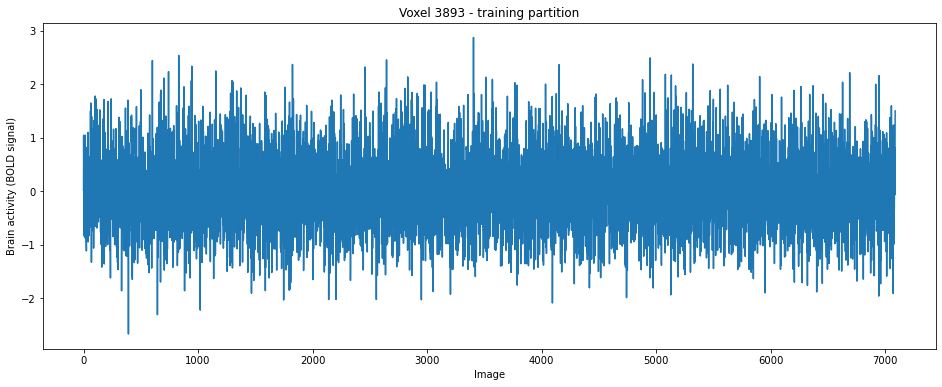

In [29]:
# Plot the brain activity of a random voxel for all images from the training partition
voxel = np.random.randint(0, fmri_train.shape[1])
plot_voxel_activity(fmri_train, voxel, 'training')

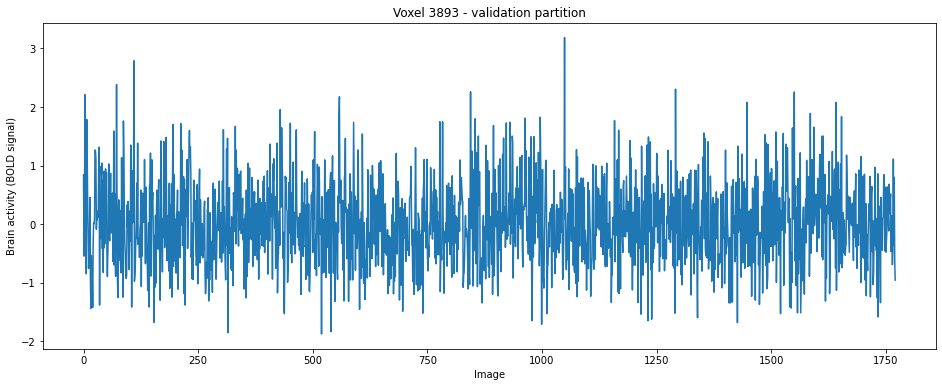

In [30]:
# Plot the brain activity of a random voxel for all images from the validation partition
plot_voxel_activity(fmri_val, voxel, 'validation')

#### 2.1.2. Brain activity of all voxels for a single image

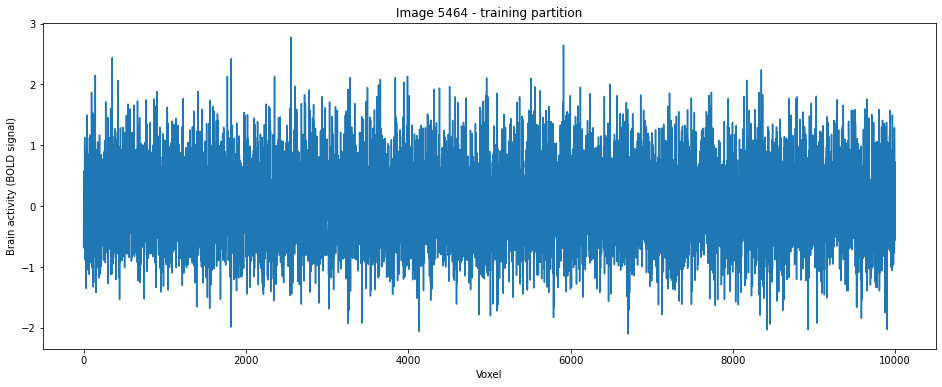

In [34]:
# Plot the brain activity of a random image for all voxels from the training partition
img_train = np.random.randint(0, fmri_train.shape[0])
plot_image_activity(fmri_train, img_train, 'training')

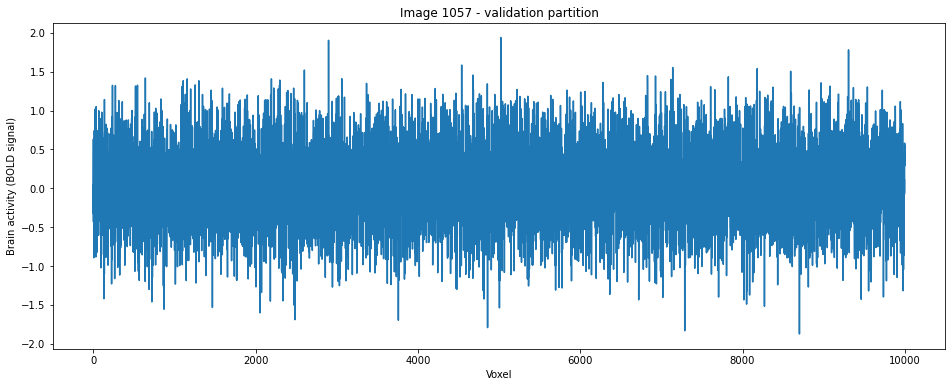

In [35]:
# Plot the brain activity of a random image for all voxels from the validation partition
img_val = np.random.randint(0, fmri_val.shape[0])
plot_image_activity(fmri_val, img_val, 'validation')

### 2.2. Stimuli - images
Show n ramdom images from a given partition.

#### 2.2.1. Training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

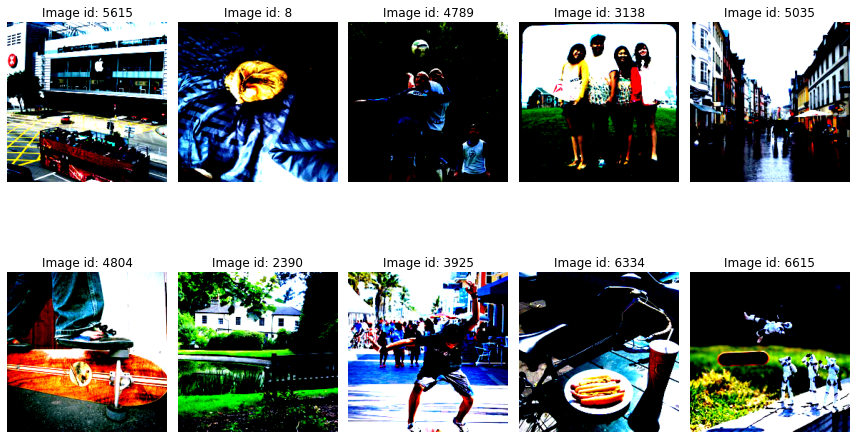

In [37]:
# Show n random images from the training set
n_img = 10 #@param
show_random_images(train_imgs_dataloader, n_img)

#### 2.2.2. Validation dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


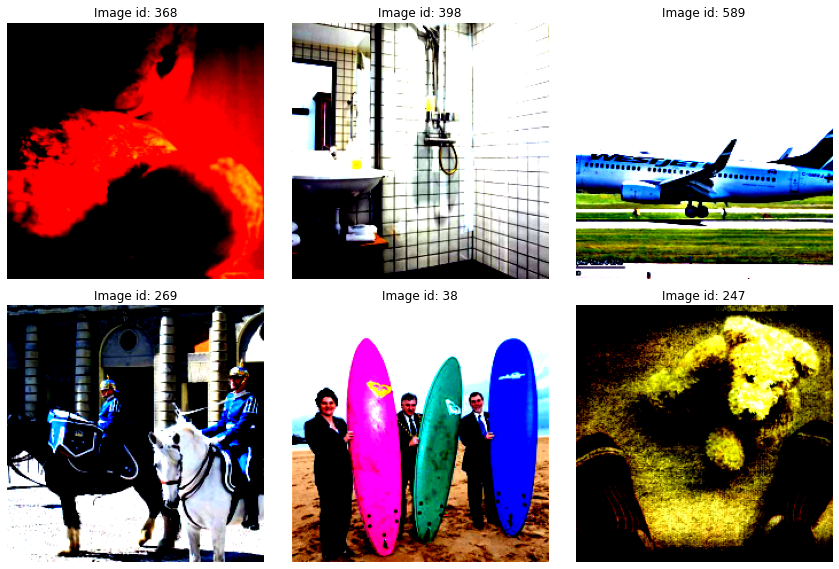

In [38]:
# Show n random images from the validation set
n_img = 6 #@param
show_random_images(val_imgs_dataloader, n_img)

#### 2.2.3. Test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


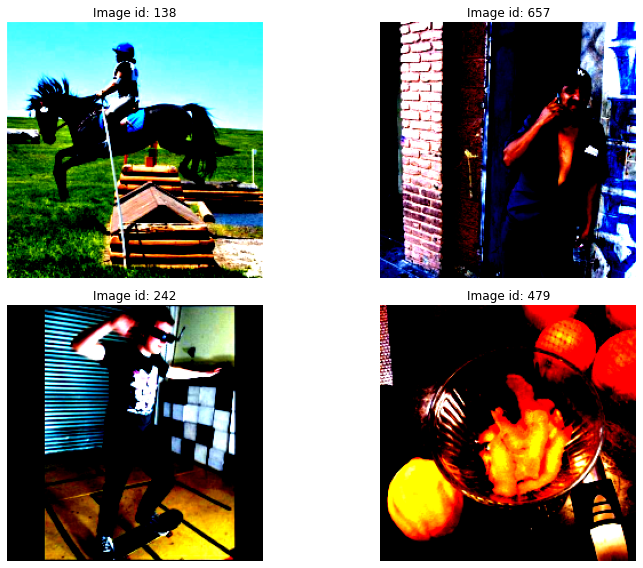

In [39]:
# Show n random images from the test set
n_img = 4 #@param
show_random_images(test_imgs_dataloader, n_img)

## 3. Feature engineering

Due to the high dimensionality of the feature representation of images using the raw pixel values (i.e., the original images have a size of 425x425 and 3 channels (RGB), which results in a feature representation of 425x425x3 = 541875 features), I use the representations obtained from different layers of pretrained CNNs to obtain a lower dimensional representation of the images. In this case, I try various layers of four different pretrained CNNs: [AlexNet][alexnet], [VGG16][vgg16], [ResNet50][resnet50], and [InceptionV3][inceptionv3]. The pretrained CNNs are available in the [torchvision package][torchvision]. To extract the features, I employ the PyTorch function `create_feature_extractor`.

The feature representations of the images is obtained by passing the images through the pretrained CNNs and extracting the output of the desired layer. The size of the feature vectors at this point is still very large, so I use PCA to overcome this problem and get a set of 30 features. I fit the PCA on the training images features, and use it to downsample the training, validation and test images features. Because of RAM limitations, I do a batch-wise partial computation of the PCA using the [`IncrementalPCA`][pca] class from scikit-learn.

I evaluate the best feature representation by training a simple linear regression model to predict the brain activity of the voxels from the feature representation of the images. The linear regression model is trained using the training set and evaluated using the validation set. The best feature representation is the one that results in the highest encoding accuracy (i.e., correlation between the predicted and actual brain activity of the voxels) on the validation set.

<font color='red'><b>NOTE:</b></font> I ran this section in a colab powered with GPU because the pretrained models required at least 10 GB of GPU RAM. So, if you want to reproduce this part of the analysis, you should run the code in colab or be sure that your local computer fulfil this requirement. Otherwise, you can skip this section, check the CSV results with the accuracy encoding for all the models on the folder `Results/Feature_eng` and move to the next section.

[alexnet]: https://pytorch.org/vision/master/models/alexnet.html
[vgg16]: https://pytorch.org/vision/master/models/generated/torchvision.models.vgg16.html#torchvision.models.vgg16
[resnet50]: https://pytorch.org/vision/master/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
[inceptionv3]: https://pytorch.org/vision/master/models/inception.html
[pca]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html
[torchvision]: https://pytorch.org/vision/stable/index.html

### 3.1. Alexnet

In [ ]:
# Load the pretrained AlexNet model from the PyTorch Hub
Alexnet = load_pretrained_model('pytorch/vision:v0.10.0', 'alexnet')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [ ]:
# Create a list with the names of the layers  that is used as feature extractors
Alexnet_layers = ['features.2', 'features.5', 'features.7', 'features.9', 'features.12', 'classifier.2', 'classifier.5', 'classifier.6']

# Create a list of feature extractor models for the chosen layers
Anet_feat_extractors = [create_feature_extractor(Alexnet, return_nodes=[layer]) for layer in Alexnet_layers]

In [ ]:
# Create a list of PCA models for the chosen layers
n_features = 30
Anet_pca_models = [fit_pca(feature_extractor, train_imgs_dataloader, n_features) for feature_extractor in Anet_feat_extractors]

100%|██████████| 142/142 [00:59<00:00,  2.39it/s]


In [ ]:
# Extract features from the training, validation and test sets for the features from all layers reduced by PCA
# and save them in a list of numpy arrays, one array per layer
Anet_feat_train = [extract_features(feature_extractor, train_imgs_dataloader, Anet_pca_models) for feature_extractor, Anet_pca_models in zip(Anet_feat_extractors, Anet_pca_models)]
Anet_feat_val = [extract_features(feature_extractor, val_imgs_dataloader, Anet_pca_models) for feature_extractor, Anet_pca_models in zip(Anet_feat_extractors, Anet_pca_models)]

100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


In [ ]:
# Free memory by deleting the variables that are no longer needed
del Alexnet, Anet_pca_models

In [ ]:
# Fit linear regressions on the training data for each layer and save the models in a list
Anet_base_models = [LinearRegression().fit(features, fmri_train) for features in Anet_feat_train]

# Use fitted linear regressions to predict the validation and test fMRI data for each layer and save the predictions in a list
Anet_fmri_val_pred = [base_model.predict(features) for base_model, features in zip(Anet_base_models, Anet_feat_val)]

In [ ]:
# Calculate the correlation coefficients between the predicted and ground truth fMRI data for each layer
Anet_corr_df = corr_layers(Anet_fmri_val_pred, fmri_val, Alexnet_layers)

# Save the correlation coefficients in a csv file
Anet_corr_df.to_csv('Anet_corr_basemodel.csv', index=False)

100%|██████████| 10000/10000 [00:14<00:00, 693.81it/s]


In [ ]:
# Calculate the median correlation coefficient per column - layer and save it in a dictionary with the layer names as keys adding the prefix 'Anet' in the keys 
# to distinguish them from the correlation coefficients of the other models
Anet_corr_median = {layer: Anet_corr_df[layer].median() for layer in Alexnet_layers}
Anet_corr_median = {'Anet_' + key: value for key, value in Anet_corr_median.items()}

# Convert the dictionary to a data frame with the layer names as index. This dataframe is used to add the median correlation coefficients of the other models
Anet_corr_median_results = pd.DataFrame.from_dict(Anet_corr_median, orient='index', columns=['Median_correlation'])

# Save the median correlation coefficients in a csv file
Anet_corr_median_results.to_csv('Anet_corr_median_basemodel.csv')

# Print the df to check the results
Anet_corr_median_results.sort_values('Median_correlation', ascending=False)

,Median_correlation
Anet_features.12,0.205023
Anet_classifier.6,0.203533
Anet_classifier.2,0.202735
Anet_classifier.5,0.202595
Anet_features.9,0.196112
Anet_features.5,0.195187
Anet_features.7,0.194441
Anet_features.2,0.185469


In [ ]:
# Free memory from gpu by deleting the variables that are no longer needed
del Anet_feat_train, Anet_feat_val, Anet_base_models, Anet_fmri_val_pred

In [ ]:
# Collect garbage and free memory from gpu
gc.collect()
torch.cuda.empty_cache()

### 3.2. VGG16

In [ ]:
# Load the pretrained vgg16 model from the PyTorch Hub
vgg16 = load_pretrained_model('pytorch/vision:v0.10.0', 'vgg16')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [ ]:
# Create a list with the names of the layers  that is be used as feature extractors
vgg16_layers = ['features.20', 'features.30', 'classifier.5', 'classifier.6']

# Create a list of feature extractor models for the chosen layers
vgg16_feat_extractors = [create_feature_extractor(vgg16, return_nodes=[layer]) for layer in vgg16_layers]

In [ ]:
# Create a list of PCA models for the chosen layers
n_features = 30
vgg16_pca_models = [fit_pca(feature_extractor, train_imgs_dataloader, n_features) for feature_extractor in vgg16_feat_extractors]

100%|██████████| 142/142 [01:27<00:00,  1.63it/s]


In [ ]:
# Extract features from the training, validation and test sets for the features from all layers reduced by PCA
# and save them in a list of numpy arrays, one array per layer
vgg16_feat_train = [extract_features(feature_extractor, train_imgs_dataloader, pca) for feature_extractor, pca in zip(vgg16_feat_extractors, vgg16_pca_models)]
vgg16_feat_val = [extract_features(feature_extractor, val_imgs_dataloader, pca) for feature_extractor, pca in zip(vgg16_feat_extractors, vgg16_pca_models)]

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


In [ ]:
# Free memory by deleting the variables that are no longer needed
del vgg16, vgg16_pca_models

In [ ]:
# Fit linear regressions on the training data for each layer and save the models in a list
vgg16_base_models = [LinearRegression().fit(features, fmri_train) for features in vgg16_feat_train]

# Use fitted linear regressions to predict the validation and test fMRI data for each layer and save the predictions in a list
vgg16_fmri_val_pred = [base_model.predict(features) for base_model, features in zip(vgg16_base_models, vgg16_feat_val)]

In [ ]:
# Calculate the correlation coefficients between the predicted and ground truth fMRI data for each layer
vgg16_corr_df = corr_layers(vgg16_fmri_val_pred, fmri_val, vgg16_layers)

# Save the correlation coefficients in a csv file
vgg16_corr_df.to_csv('vgg16_corr_basemodel.csv', index=False)

100%|██████████| 10000/10000 [00:13<00:00, 719.49it/s]


In [ ]:
# Calculate the median correlation coefficient per column - layer and save it in a dictionary with the layer names as keys adding the prefix 'Anet' in the keys 
# to distinguish them from the correlation coefficients of the other models
vgg16_corr_median = {layer: vgg16_corr_df[layer].median() for layer in vgg16_layers}
vgg16_corr_median = {'Resnet_' + key: value for key, value in vgg16_corr_median.items()}

# Convert the dictionary to a data frame with the layer names as index. This dataframe is used to add the median correlation coefficients of the other models
vgg16_corr_median_results = pd.DataFrame.from_dict(vgg16_corr_median, orient='index', columns=['Median_correlation'])

# Save the median correlation coefficients in a csv file
vgg16_corr_median_results.to_csv('vgg16_corr_median_basemodel.csv')

# Print the df to check the results
vgg16_corr_median_results.sort_values('Median_correlation', ascending=False)

,Median_correlation
Resnet_classifier.5,0.198410
Resnet_features.30,0.195494
Resnet_classifier.6,0.191841
Resnet_features.20,0.170817


In [ ]:
# Free memory from gpu by deleting the variables that are no longer needed
del vgg16_feat_train, vgg16_feat_val, vgg16_base_models, vgg16_fmri_val_pred

In [ ]:
# Collect garbage and free memory from gpu
gc.collect()
torch.cuda.empty_cache()

### 3.3. Resnet50

In [ ]:
# Load the pretrained Resnet model from the PyTorch Hub
Resnet50 = load_pretrained_model('pytorch/vision:v0.10.0', 'resnet50')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.relu_1', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.0.add', 'layer1.0.relu_2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.relu_1', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.add', 'layer1.1.relu_2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.relu_1', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.add', 'layer1.2.relu_2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.relu_1', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_2', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.relu_1', 'layer2.1.conv3', 'layer2.1.bn3', 'layer2.1.add', 'layer2.1.rel

In [ ]:
# Create a list with the names of the layers  that is be used as feature extractors
Resnet_layers = ['layer1.1.conv1', 'layer2.3.conv2', 'layer3.5.conv3', 'layer4.2.conv3', 'avgpool']

# Create a list of feature extractor models for the chosen layers
Resnet_feat_extractors = [create_feature_extractor(Resnet50, return_nodes=[layer]) for layer in Resnet_layers]

In [ ]:
# Create a list of PCA models for the chosen layers
n_features = 30
Rnet_pca_models = [fit_pca(feature_extractor, train_imgs_dataloader, n_features) for feature_extractor in Resnet_feat_extractors]

100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


In [ ]:
# Extract features from the training, validation and test sets for the features from all layers reduced by PCA
# and save them in a list of numpy arrays, one array per layer
Rnet_feat_train = [extract_features(feature_extractor, train_imgs_dataloader, pca) for feature_extractor, pca in zip(Resnet_feat_extractors, Rnet_pca_models)]
Rnet_feat_val = [extract_features(feature_extractor, val_imgs_dataloader, pca) for feature_extractor, pca in zip(Resnet_feat_extractors, Rnet_pca_models)]

100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


In [ ]:
# Free memory by deleting the variables that are no longer needed
del Resnet50, Rnet_pca_models

In [ ]:
# Fit linear regressions on the training data for each layer and save the models in a list
Rnet_base_models = [LinearRegression().fit(features, fmri_train) for features in Rnet_feat_train]

# Use fitted linear regressions to predict the validation and test fMRI data for each layer and save the predictions in a list
Rnet_fmri_val_pred = [base_model.predict(features) for base_model, features in zip(Rnet_base_models, Rnet_feat_val)]

In [ ]:
# Calculate the correlation coefficients between the predicted and ground truth fMRI data for each layer
Rnet_corr_df = corr_layers(Rnet_fmri_val_pred, fmri_val, Resnet_layers)

# Save the correlation coefficients in a csv file
Rnet_corr_df.to_csv('Rnet50_corr_basemodel.csv', index=False)

100%|██████████| 10000/10000 [00:13<00:00, 737.95it/s]


In [ ]:
# Calculate the median correlation coefficient per column - layer and save it in a dictionary with the layer names as keys adding the prefix 'Resnet50' in the keys 
# to distinguish them from the correlation coefficients of the other models
Rnet_corr_median = {layer: Rnet_corr_df[layer].median() for layer in Resnet_layers}
Rnet_corr_median = {'Resnet50_' + key: value for key, value in Rnet_corr_median.items()}

# Convert the dictionary to a data frame with the layer names as index. This dataframe is be used to add the median correlation coefficients of the other models
Rnet_corr_median_results = pd.DataFrame.from_dict(Rnet_corr_median, orient='index', columns=['Median_correlation'])

# Save the median correlation coefficients in a csv file
Rnet_corr_median_results.to_csv('Rnet50_corr_median_basemodel.csv')

# Print the df to check the results
Rnet_corr_median_results.sort_values('Median_correlation', ascending=False)

,Median_correlation
Resnet50_layer1.1.conv1,0.170710
Resnet50_avgpool,0.157940
Resnet50_layer2.3.conv2,0.135136
Resnet50_layer3.5.conv3,0.127329
Resnet50_layer4.2.conv3,0.120823


In [ ]:
# Free memory from gpu by deleting the variables that are no longer needed
del Rnet_feat_train, Rnet_feat_val, Rnet_base_models, Rnet_fmri_val_pred

In [ ]:
# Collect garbage and free memory from gpu
gc.collect()
torch.cuda.empty_cache()

### 3.4. InceptionV3

In [ ]:
# Load the pretrained InceptionV3 model from the PyTorch Hub
InceptV3 = load_pretrained_model('pytorch/vision:v0.10.0', 'inception_v3')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


['x', 'Conv2d_1a_3x3.conv', 'Conv2d_1a_3x3.bn', 'Conv2d_1a_3x3.relu', 'Conv2d_2a_3x3.conv', 'Conv2d_2a_3x3.bn', 'Conv2d_2a_3x3.relu', 'Conv2d_2b_3x3.conv', 'Conv2d_2b_3x3.bn', 'Conv2d_2b_3x3.relu', 'maxpool1', 'Conv2d_3b_1x1.conv', 'Conv2d_3b_1x1.bn', 'Conv2d_3b_1x1.relu', 'Conv2d_4a_3x3.conv', 'Conv2d_4a_3x3.bn', 'Conv2d_4a_3x3.relu', 'maxpool2', 'Mixed_5b.branch1x1.conv', 'Mixed_5b.branch1x1.bn', 'Mixed_5b.branch1x1.relu', 'Mixed_5b.branch5x5_1.conv', 'Mixed_5b.branch5x5_1.bn', 'Mixed_5b.branch5x5_1.relu', 'Mixed_5b.branch5x5_2.conv', 'Mixed_5b.branch5x5_2.bn', 'Mixed_5b.branch5x5_2.relu', 'Mixed_5b.branch3x3dbl_1.conv', 'Mixed_5b.branch3x3dbl_1.bn', 'Mixed_5b.branch3x3dbl_1.relu', 'Mixed_5b.branch3x3dbl_2.conv', 'Mixed_5b.branch3x3dbl_2.bn', 'Mixed_5b.branch3x3dbl_2.relu', 'Mixed_5b.branch3x3dbl_3.conv', 'Mixed_5b.branch3x3dbl_3.bn', 'Mixed_5b.branch3x3dbl_3.relu', 'Mixed_5b.avg_pool2d', 'Mixed_5b.branch_pool.conv', 'Mixed_5b.branch_pool.bn', 'Mixed_5b.branch_pool.relu', 'Mixed_5b.c

/usr/local/lib/python3.10/dist-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


In [ ]:
# Create a list with the names of the layers  that is used as feature extractors
InceptV3_layers = ['Mixed_5c.branch1x1.conv', 'Conv2d_4a_3x3.conv', 'Mixed_6b.branch1x1.conv', 'Mixed_6c.branch7x7_2.conv', 'Mixed_7c.branch_pool.conv', 'avgpool']

# Create a list of feature extractor models for the chosen layers
Inv3_feat_extractors = [create_feature_extractor(InceptV3, return_nodes=[layer]) for layer in InceptV3_layers]

In [ ]:
# Create a list of PCA models for the chosen layers
n_features = 30
Inv3_pca_models = [fit_pca(feature_extractor, train_imgs_dataloader, n_features) for feature_extractor in Inv3_feat_extractors]

100%|██████████| 142/142 [01:05<00:00,  2.17it/s]


In [ ]:
# Extract features from the training, validation and test sets for the features from all layers reduced by PCA
# and save them in a list of numpy arrays, one array per layer
Inv3_feat_train = [extract_features(feature_extractor, train_imgs_dataloader, pca) for feature_extractor, pca in zip(Inv3_feat_extractors, Inv3_pca_models)]
Inv3_feat_val = [extract_features(feature_extractor, val_imgs_dataloader, pca) for feature_extractor, pca in zip(Inv3_feat_extractors, Inv3_pca_models)]

100%|██████████| 36/36 [00:15<00:00,  2.28it/s]


In [ ]:
# Free memory by deleting the variables that are no longer needed
del InceptV3, Inv3_pca_models

In [ ]:
# Fit linear regressions on the training data for each layer and save the models in a list
Inv3_base_models = [LinearRegression().fit(features, fmri_train) for features in Inv3_feat_train]

# Use fitted linear regressions to predict the validation and test fMRI data for each layer and save the predictions in a list
Inv3_fmri_val_pred = [base_model.predict(features) for base_model, features in zip(Inv3_base_models, Inv3_feat_val)]

In [ ]:
# Calculate the correlation coefficients between the predicted and ground truth fMRI data for each layer
Inv3_corr_df = corr_layers(Inv3_fmri_val_pred, fmri_val, InceptV3_layers)

# Save the correlation coefficients in a csv file
Inv3_corr_df.to_csv('Inv3_corr_basemodel.csv', index=False)

100%|██████████| 10000/10000 [00:11<00:00, 870.43it/s]


In [ ]:
# Calculate the median correlation coefficient per column - layer and save it in a dictionary with the layer names as keys adding the prefix 'Inv3' in the keys 
# to distinguish them from the correlation coefficients of the other models
Inv3_corr_median = {layer: Inv3_corr_df[layer].median() for layer in InceptV3_layers}
Inv3_corr_median = {'Inv3_' + key: value for key, value in Inv3_corr_median.items()}

# Convert the dictionary to a data frame with the layer names as index. This dataframe is used to add the median correlation coefficients of the other models
Inv3_corr_median_results = pd.DataFrame.from_dict(Inv3_corr_median, orient='index', columns=['Median_correlation'])

# Save the median correlation coefficients in a csv file
Inv3_corr_median_results.to_csv('Inv3_corr_median_basemodel.csv')

# Print the df to check the results
Inv3_corr_median_results.sort_values('Median_correlation', ascending=False)

,Median_correlation
Inv3_Mixed_6c.branch7x7_2.conv,0.157622
Inv3_Mixed_5c.branch1x1.conv,0.150074
Inv3_Mixed_6b.branch1x1.conv,0.148523
Inv3_Conv2d_4a_3x3.conv,0.142102
Inv3_Mixed_7c.branch_pool.conv,0.140154
Inv3_avgpool,0.118583


In [ ]:
# Free memory from gpu by deleting the variables that are no longer needed
del Inv3_feat_train, Inv3_feat_val, Inv3_base_models, Inv3_fmri_val_pred

In [ ]:
# Collect garbage and free memory from gpu
gc.collect()
torch.cuda.empty_cache()

### 3.5. Selection of the best feature representation

In [43]:
# Import csv files with the results of the encoding accuracy of the models
# Alexnet 
Alex_acc = pd.read_csv('Results/Feature_eng/Median_corr/Anet_corr_median_basemodel.csv', index_col=0)

# VGG16
VGG16_acc = pd.read_csv('Results/Feature_eng/Median_corr/vgg16_corr_median_basemodel.csv', index_col=0)

# Resnet50
Rnet_acc = pd.read_csv('Results/Feature_eng/Median_corr/Rnet50_corr_median_basemodel.csv', index_col=0)

# InceptionV3
Inv3_acc = pd.read_csv('Results/Feature_eng/Median_corr/Inv3_corr_median_basemodel.csv', index_col=0)

In [45]:
# Concatenate the data frames with the results of the encoding accuracy of the models
acc_results_allmodels = pd.concat([Alex_acc, VGG16_acc, Rnet_acc, Inv3_acc])

# Sort the data frame by the median correlation coefficient
acc_results_allmodels = acc_results_allmodels.sort_values('Median_correlation', ascending=False)

# Save the data frame in a csv file
acc_results_allmodels.to_csv('Results/Feature_eng/Median_corr/acc_results_allmodels.csv')

# Show the sorted data frame
acc_results_allmodels

,Median_correlation
Anet_features.12,0.205023
Anet_classifier.6,0.203533
Anet_classifier.2,0.202735
Anet_classifier.5,0.202595
Resnet_classifier.5,0.198410
Anet_features.9,0.196112
Resnet_features.30,0.195494
Anet_features.5,0.195187
Anet_features.7,0.194441
Resnet_classifier.6,0.191841


As shown in the previous data frame of the encoding accuracy for all the pretrained models, the best feature representation is the one obtained from the layer `features.12` of the **Alexnet** CNN. So, I use this feature representation to build the machine learning models to predict the brain activity of the voxels from the images.

## 4. Bulding and evaluating machine learning models

Now, I train 6 different machine learnning algorithms (linear regression - base model, ridge regression, lasso regression, elasticnet regression, k-nearest neighbours regressor, and decision tree regressor) to predict the brain activity of the voxels from the feature representation of the images. In this project, the learning task is a **multioutput regression problem**, where the input is the feature representation of the images and the output is the brain activity of all the voxels. Each regressor maps from the feature space to each voxel, so there is a separate encoding model per voxel, leading to **voxelwise encoding models**. Therefore, every model trained with this dataset have 10000 independently regression models with n coeficients each (the number of features).

The models were trained using the training set and evaluate them using the validation set. The best model would be the one that results in the highest encoding accuracy (i.e., correlation between the predicted and actual brain activity of the voxels) on the validation set. 

The creation of the encoding algorithms comprises the following steps:

1. Extract the best feature representation with the `features12` layer of Alexnet. 

2. Create machine learning models to map the features extracted with AlexNet to the brain activity (fMRI) responses.

3. Evaluate the encoding models using the validation set.

### 4.1. Feature extraction with the best representation

#### 4.1.1 Load the pretrained AlexNet

In [ ]:
# Load the pretrained AlexNet model from the PyTorch Hub
Alexnet = load_pretrained_model('pytorch/vision:v0.10.0', 'alexnet')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


#### 4.1.2 Extract and downsample the AlexNet features

In [ ]:
# Set the best layer obatiend from the previous section. You can choose a differnt layer by changing this variable
best_layer = 'features.12'

# Create a feature extractor for the best feature represetnation 
feature_extractor = create_feature_extractor(Alexnet, return_nodes=[best_layer])

#### 4.1.3. Redefine the dataloaders
This step is needed to increase the batch size to 300 and the number of features obtained with the PCA to 100 (in the previous [section of feature engineering](#3-feature-engineering) it was 30). This is because a higher number of features can be a better representation of the images.

In [ ]:
batch_size = 300 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform), 
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform), 
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform), 
    batch_size=batch_size
)

#### 4.1.4. Reduce the dimensionality of the feature matrix for the images

The following function extracts the AlexNet features from each image batch, and partially computes the PCA to reduce the dimensionality of the feature matrix for the images.

In [ ]:
# Create PCA model for the best layer
n_features = 100
pca = fit_pca(feature_extractor, train_imgs_dataloader, n_features)

100%|██████████| 24/24 [06:52<00:00, 17.18s/it]


I use the fitted pca do reduce the dimensionality of the training, validation and test images features.

In [ ]:
# Extract features from the training, validation and test sets for the features from 
# the best layer
features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_test.shape)
print('(Test stimulus images × PCA features)')

100%|██████████| 4/4 [00:39<00:00,  9.83s/it]


Training images features:
(7086, 100)
(Training stimulus images × PCA features)

Validation images features:
(1771, 100)
(Validation stimulus images × PCA features)

Test images features:
(984, 100)
(Test stimulus images × PCA features)


Let's free up RAM by deleting the AlexNet model and PCA parameters.

In [ ]:
del Alexnet, pca

In [ ]:
# Collect garbage and free memory from gpu
gc.collect()
torch.cuda.empty_cache()

### 4.2 ML models to map the features extracted with AlexNet to the brain activity (fMRI) responses

First, I build a linear regression model as a baseline model. Then, I create 3 regularized linear regression models (ridge regression, lasso regression, and elasticnet regression) using cross validation to find the best hyperparameters. Finally, I build 2 non-linear regression models (k-nearest neighbours regressor, and decision tree regressor).

#### 4.2.1. Base model - simple linear regression

In [ ]:
# Fit linear regressions on the training data
lr_base_model = LinearRegression().fit(features_train, fmri_train)

In [ ]:
# Use fitted linear regressions to predict the validation fMRI
fmri_val_pred_lrbasemod = lr_base_model.predict(features_val)

In [ ]:
# Calculate correlation coefficients across all voxels 
corr_lrbasemodel = corr_allvoxels(fmri_val_pred_lrbasemod, fmri_val)

# Save the correlation coefficients in a csv file
np.savetxt('corr_lrbasemodel.csv', corr_lrbasemodel, delimiter=',')

100%|██████████| 10000/10000 [00:24<00:00, 408.15it/s]


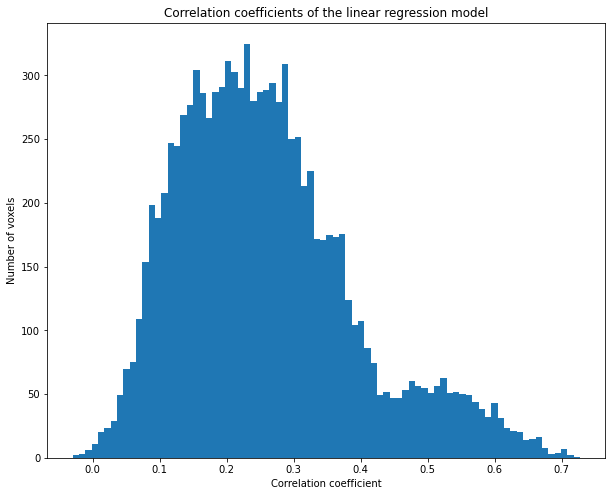

In [74]:
# Plot a histogram of the correlation coefficients
plot_corr_hist(corr_lrbasemodel, 'Correlation coefficients of the linear regression model', bins=80)

In [87]:
# Create a dataframe with the top 10 voxels and their scores
top_voxels_lr = voxels_df(corr_lrbasemodel, 10, top=True)

# Show the dataframe
top_voxels_lr

,voxel,score
1,2377,0.73
2,4580,0.72
3,8876,0.71
4,2298,0.71
5,3652,0.71
6,4013,0.71
7,8542,0.70
8,6687,0.70
9,3498,0.70
10,8448,0.70


In [ ]:
# Plot the fmri predictions vs the fmri values for the top 1 voxel
plot_fmri_pred(top_voxels_lr['Voxel'].iloc[0], fmri_val, fmri_val_pred_lrbasemod)

In [88]:
# Create a dataframe with the bottom 10 voxels and their scores
bottom_voxels_lr = voxels_df(corr_lrbasemodel, 10, top=False)

# Show the dataframe
bottom_voxels_lr

,voxel,score
1,3275,-0.03
2,1645,-0.02
3,8429,-0.02
4,7879,-0.01
5,5805,-0.01
6,8398,-0.01
7,1268,-0.01
8,3379,-0.00
9,1958,-0.00
10,3793,-0.00


In [ ]:
# Plot the fmri predictions vs the fmri values for teh voxel with the lowest correlation coefficient
plot_fmri_pred(bottom_voxels_lr['Voxel'].iloc[0], fmri_val, fmri_val_pred_lrbasemod)

In [ ]:
# Calculate the mean correlation across voxels
mean_corr_lrbasemodel = np.mean(corr_lrbasemodel)
print('Mean correlation Linear reg - base model: ', mean_corr_lrbasemodel)

Mean correlation Linear reg - base model:  0.2587149794586322


In [ ]:
# Create a data frame to store the mean correlations for all the models
mean_corr_df = pd.DataFrame(columns=['Mean_correlation'])

# Add the mean correlation of the base model to the data frame
mean_corr_df.loc['Linear_reg_base_model'] = mean_corr_lrbasemodel

# Show the dataframe 
mean_corr_df

,Mean_correlation
Linear_reg_base_model,0.258715


#### 4.2.2. Ridge regression with built-in cross-validation

In [ ]:
# Fit ridge regression on the training data
Ridge = RidgeCV(alphas=[1e-2, 1e-1, 1, 10, 100], cv =3, random_state=224).fit(features_train, fmri_train)

# Use fitted ridge regression with the best alpha to predict the validation fMRI
fmri_val_pred_ridge = Ridge.predict(features_val)

In [ ]:
# Print the best alpha parameter
Ridge.alpha_

1.0

In [ ]:
# Calculate correlation coefficients across all voxels
corr_ridge = corr_allvoxels(fmri_val_pred_ridge, fmri_val)

# Save the correlation coefficients in a csv file
np.savetxt('corr_ridge.csv', corr_ridge, delimiter=',')

100%|██████████| 10000/10000 [00:14<00:00, 697.35it/s]


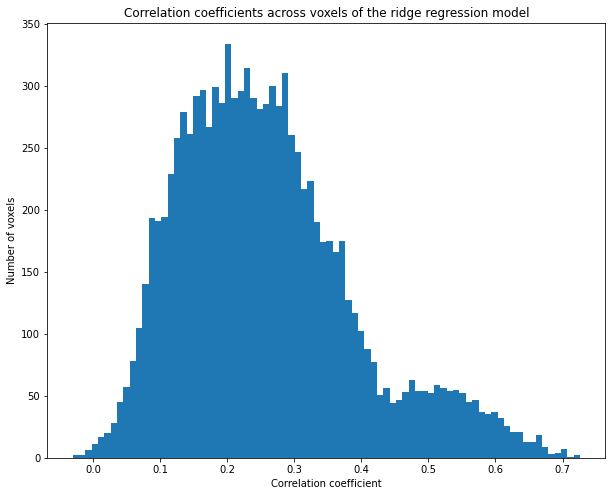

In [67]:
# Plot a histogram of the correlation coefficients
plt.figure(figsize=(10, 8))
plt.hist(corr_ridge, bins=80)
plt.xlabel('Correlation coefficient')
plt.ylabel('Number of voxels')
plt.title('Correlation coefficients across voxels of the ridge regression model')
plt.show()

In [90]:
# Create a dataframe with the top 10 voxels and their scores
top_voxels_ridge = voxels_df(corr_ridge, 10, top=True)

# Show the dataframe
top_voxels_ridge

,voxel,score
1,2377,0.73
2,4580,0.72
3,8876,0.71
4,2298,0.71
5,3652,0.71
6,4013,0.70
7,8542,0.70
8,6687,0.70
9,3498,0.70
10,8448,0.70


In [ ]:
# Plot the fmri predictions vs the fmri values for the top 1 voxel
plot_fmri_pred(top_voxels_ridge['Voxel'].iloc[0], fmri_val, fmri_val_pred_ridge)

In [91]:
# Create a dataframe with the bottom 10 voxels and their scores
bottom_voxels_ridge = voxels_df(corr_ridge, 10, top=False)

# Show the dataframe
bottom_voxels_ridge

,voxel,score
1,3275,-0.03
2,1645,-0.02
3,8429,-0.02
4,7879,-0.01
5,5805,-0.01
6,1268,-0.01
7,8398,-0.01
8,3379,-0.00
9,3793,-0.00
10,5193,-0.00


In [ ]:
# Plot the fmri predictions vs the fmri values for the voxel with the lowest correlation coefficient
plot_fmri_pred(bottom_voxels_ridge['Voxel'].iloc[0], fmri_val, fmri_val_pred_ridge)

In [ ]:
# Calculate the mean correlation across voxels
mean_corr_ridge = np.mean(corr_ridge)
print(f'Mean correlation Ridge_alpha{Ridge.alpha_}: ', mean_corr_ridge)

Mean correlation Ridge_alpha1.0:  0.2594294707593004


In [ ]:
# Add the mean correlation of the ridge model to the data frame
mean_corr_df.loc[f'Ridge_alpha{Ridge.alpha_}'] = mean_corr_ridge

# Show the dataframe 
mean_corr_df.sort_values('Mean_correlation', ascending=False)

,Mean_correlation
Ridge_alpha1.0,0.259429
Linear_reg_base_model,0.258715


#### 4.2.3. Lasso regression with built-in cross-validation and multioutput

In [ ]:
# Fit lasso regression on the training data
Lasso = MultiTaskLassoCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=3, random_state=224, verbose=True).fit(features_train, fmri_train)

# Use fitted lasso regression with the best alpha to predict the validation fMRI
fmri_val_pred_lasso = Lasso.predict(features_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
............[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.0min finished


In [ ]:
# Print the best alpha parameter
Lasso.alpha_

0.01

In [ ]:
# Calculate correlation coefficients across all voxels
corr_lasso = corr_allvoxels(fmri_val_pred_lasso, fmri_val)

# Save the correlation coefficients in a csv file
np.savetxt('corr_lasso.csv', corr_lasso, delimiter=',')

100%|██████████| 10000/10000 [00:14<00:00, 705.49it/s]


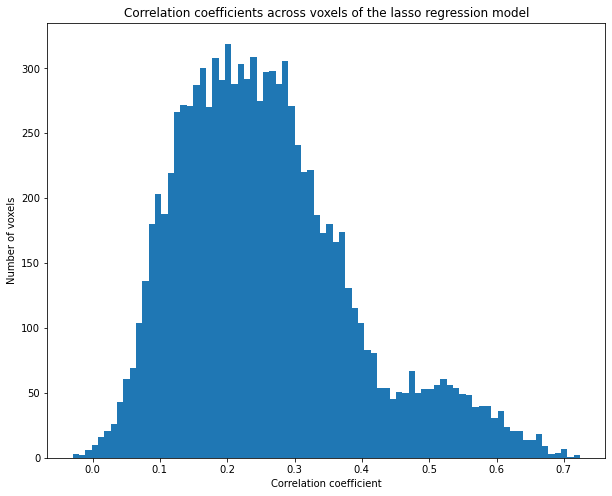

In [66]:
# Plot a histogram of the correlation coefficients
plt.figure(figsize=(10, 8))
plt.hist(corr_lasso, bins=80)
plt.xlabel('Correlation coefficient')
plt.ylabel('Number of voxels')
plt.title('Correlation coefficients across voxels of the lasso regression model')
plt.show()

In [92]:
# Create a dataframe with the top 10 voxels and their scores
top_voxels_lasso = voxels_df(corr_lasso, 10, top=True)

# Show the dataframe
top_voxels_lasso

,voxel,score
1,2377,0.72
2,4580,0.72
3,8876,0.71
4,3652,0.71
5,2298,0.70
6,4013,0.70
7,8542,0.70
8,6687,0.70
9,8448,0.70
10,3498,0.70


In [ ]:
# Plot the fmri predictions vs the fmri values for the top 1 voxel
plot_fmri_pred(top_voxels_lasso['Voxel'].iloc[0], fmri_val, fmri_val_pred_lasso)

In [93]:
# Create a dataframe with the bottom 10 voxels and their scores
bottom_voxels_lasso = voxels_df(corr_lasso, 10, top=False)

# Show the dataframe
bottom_voxels_lasso

,voxel,score
1,3275,-0.03
2,1645,-0.02
3,8429,-0.02
4,7879,-0.01
5,5805,-0.01
6,1268,-0.01
7,3379,-0.01
8,8398,-0.01
9,5193,-0.00
10,3793,-0.00


In [ ]:
# Plot the fmri predictions vs the fmri values for the voxel with the lowest correlation coefficient
plot_fmri_pred(bottom_voxels_lasso['Voxel'].iloc[0], fmri_val, fmri_val_pred_lasso)

In [ ]:
# Calculate the mean correlation across voxels
mean_corr_lasso = np.mean(corr_lasso)
print(f'Mean correlation Lasso_alpha{Lasso.alpha_}: ', mean_corr_lasso)

Mean correlation Lasso_alpha0.01:  0.2596446540637554


In [ ]:
# Add the mean correlation of the ridge model to the data frame
mean_corr_df.loc[f'Lasso_alpha{Lasso.alpha_}'] = mean_corr_lasso

# Show the dataframe 
mean_corr_df.sort_values('Mean_correlation', ascending=False)

,Mean_correlation
Lasso_alpha0.01,0.259645
Ridge_alpha1.0,0.259429
Linear_reg_base_model,0.258715


#### 4.2.4. Elasticnet regression with built-in cross-validation 

In [ ]:
# Fit elastic net regression on the training data
Elasticnet = MultiTaskElasticNetCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=3, random_state=224, verbose=True).fit(features_train, fmri_train)

# Use fitted elastic with the best alpha net regression to predict the validation fMRI
fmri_val_pred_enet = Elasticnet.predict(features_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
............[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.3min finished


In [ ]:
# Print the best alpha parameter
Elasticnet.alpha_

0.001

In [ ]:
# Calculate correlation coefficients across all voxels
corr_enet = corr_allvoxels(fmri_val_pred_enet, fmri_val)

# Save the correlation coefficients in a csv file
np.savetxt('corr_enet.csv', corr_enet, delimiter=',')

100%|██████████| 10000/10000 [00:14<00:00, 710.81it/s]


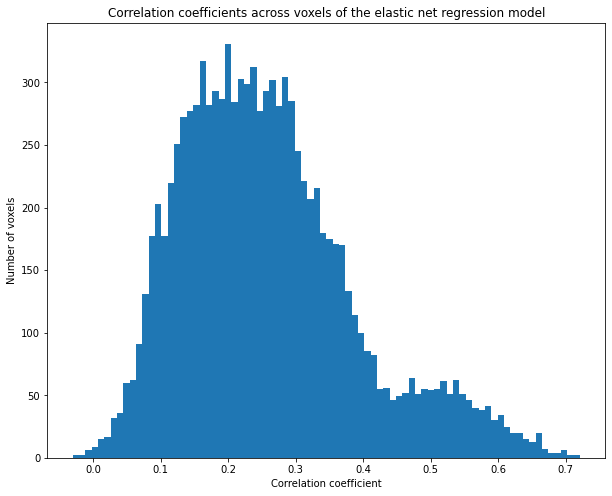

In [65]:
# Plot a histogram of the correlation coefficients
plt.figure(figsize=(10, 8))
plt.hist(corr_enet, bins=80)
plt.xlabel('Correlation coefficient')
plt.ylabel('Number of voxels')
plt.title('Correlation coefficients across voxels of the elastic net regression model')
plt.show()

In [94]:
# Create a dataframe with the top 10 voxels and their scores
top_voxels_enet = voxels_df(corr_enet, 10, top=True)

# Show the dataframe
top_voxels_enet

,voxel,score
1,2377,0.72
2,4580,0.71
3,8876,0.71
4,3652,0.70
5,2298,0.70
6,8542,0.70
7,4013,0.70
8,6687,0.70
9,8448,0.70
10,3498,0.69


In [ ]:
# Plot the fmri predictions vs the fmri values for the top 1 voxel
plot_fmri_pred(top_voxels_enet['Voxel'].iloc[0], fmri_val, fmri_val_pred_enet)

In [95]:
# Create a dataframe with the bottom 10 voxels and their scores
bottom_voxels_enet = voxels_df(corr_enet, 10, top=False)

# Show the dataframe
bottom_voxels_enet

,voxel,score
1,3275,-0.03
2,1645,-0.02
3,8429,-0.02
4,7879,-0.02
5,5805,-0.01
6,1268,-0.01
7,3379,-0.01
8,5193,-0.00
9,4248,-0.00
10,8398,-0.00


In [ ]:
# Plot the fmri predictions vs the fmri values for the voxel with the lowest correlation coefficient
plot_fmri_pred(bottom_voxels_enet['Voxel'].iloc[0], fmri_val, fmri_val_pred_enet)

In [ ]:
# Calculate the mean correlation across voxels
mean_corr_enet = np.mean(corr_enet)
print(f'Mean correlation Elasticnet_alpha{Elasticnet.alpha_}: ', mean_corr_enet)

Mean correlation Elasticnet_alpha0.001:  0.25928549455070854


In [ ]:
# Add the mean correlation of the ridge model to the data frame
mean_corr_df.loc[f'ElasticNet_alpha{Elasticnet.alpha_}'] = mean_corr_enet

# Show the dataframe 
mean_corr_df.sort_values('Mean_correlation', ascending=False)

,Mean_correlation
Lasso_alpha0.01,0.259645
Ridge_alpha1.0,0.259429
ElasticNet_alpha0.001,0.259285
Linear_reg_base_model,0.258715


#### 4.2.5. Kneighbours

In [ ]:
# Fit the k-nearest neighbors regressor on the training data
Kneig = KNeighborsRegressor().fit(features_train, fmri_train)

# Use fitted k-nearest neighbors regressor to predict the validation fMRI
fmri_val_pred_kneig = Kneig.predict(features_val)

In [ ]:
# Calculate correlation coefficients across all voxels
corr_kneig = corr_allvoxels(fmri_val_pred_kneig, fmri_val)

# Save the correlation coefficients in a csv file
np.savetxt('corr_kneig.csv', corr_kneig, delimiter=',')

100%|██████████| 10000/10000 [00:13<00:00, 720.48it/s]


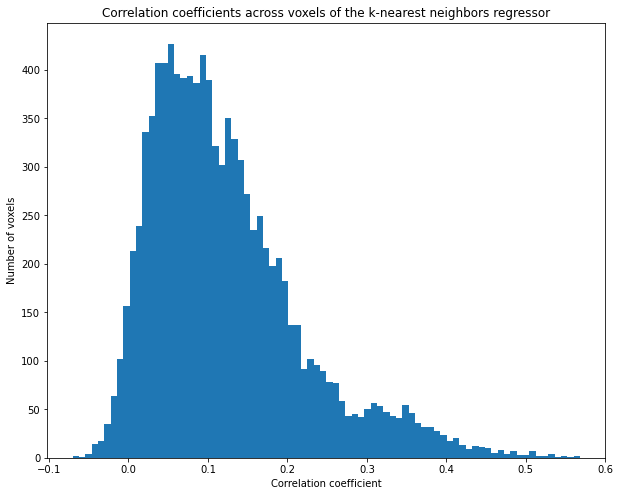

In [70]:
# Plot a histogram of the correlation coefficients
plt.figure(figsize=(10, 8))
plt.hist(corr_kneig, bins=80)
plt.xlabel('Correlation coefficient')
plt.ylabel('Number of voxels')
plt.title('Correlation coefficients across voxels of the k-nearest neighbors regressor')
plt.show()

In [96]:
# Create a dataframe with the top 10 voxels and their scores
top_voxels_kneig = voxels_df(corr_kneig, 10, top=True)

# Show the dataframe
top_voxels_kneig

,voxel,score
1,2377,0.57
2,8542,0.56
3,8876,0.55
4,3104,0.55
5,4580,0.55
6,334,0.54
7,1527,0.53
8,3652,0.53
9,202,0.53
10,9160,0.53


In [ ]:
# Plot the fmri predictions vs the fmri values for the top 1 voxel
plot_fmri_pred(top_voxels_kneig['Voxel'].iloc[0], fmri_val, fmri_val_pred_kneig)

In [97]:
# Create a dataframe with the bottom 10 voxels and their scores
bottom_voxels_kneig = voxels_df(corr_kneig, 10, top=False)

# Show the dataframe
bottom_voxels_kneig

,voxel,score
1,6107,-0.07
2,695,-0.07
3,6201,-0.06
4,9679,-0.05
5,5474,-0.05
6,8538,-0.05
7,4726,-0.05
8,1267,-0.05
9,5663,-0.04
10,2739,-0.04


In [ ]:
# Plot the fmri predictions vs the fmri values for the voxel with the lowest correlation coefficient
plot_fmri_pred(bottom_voxels_kneig['Voxel'].iloc[0], fmri_val, fmri_val_pred_kneig)

In [ ]:
# Calculate the mean correlation across voxels
mean_corr_kneig = np.mean(corr_kneig)
print('Mean correlation KNeighborsRegressor: ', mean_corr_kneig)

Mean correlation KNeighborsRegressor:  0.1223801499368381


In [ ]:
# Add the mean correlation of the KNeighborsRegressor model to the data frame
mean_corr_df.loc['KNeighborsRegressor'] = mean_corr_kneig

# Show the dataframe 
mean_corr_df.sort_values('Mean_correlation', ascending=False)

,Mean_correlation
Lasso_alpha0.01,0.259645
Ridge_alpha1.0,0.259429
ElasticNet_alpha0.001,0.259285
Linear_reg_base_model,0.258715
KNeighborsRegressor,0.122380


#### 4.2.6. Decision tree

In [ ]:
# Fit the decision tree regressor on the training data
DT = DecisionTreeRegressor(random_state=224).fit(features_train, fmri_train)

# Use fitted decision tree regressor to predict the validation fMRI
fmri_val_pred_dt = DT.predict(features_val)

In [ ]:
# Calculate correlation coefficients across all voxels
corr_dt = corr_allvoxels(fmri_val_pred_dt, fmri_val)

# Save the correlation coefficients in a csv file
np.savetxt('corr_dt.csv', corr_dt, delimiter=',')

100%|██████████| 10000/10000 [00:14<00:00, 687.03it/s]


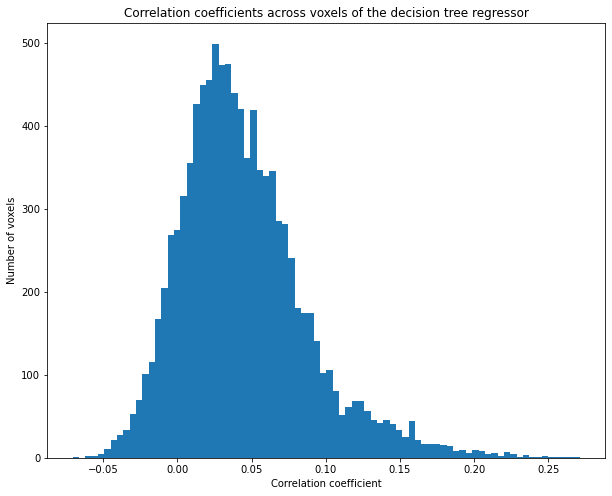

In [72]:
# Plot a histogram of the correlation coefficients
plt.figure(figsize=(10, 8))
plt.hist(corr_dt, bins=80)
plt.xlabel('Correlation coefficient')
plt.ylabel('Number of voxels')
plt.title('Correlation coefficients across voxels of the decision tree regressor')
plt.show()

In [98]:
# Create a dataframe with the top/bottom 10 voxels and their scores
top_voxels_dt = voxels_df(corr_dt, 10, top=True)

# Show the dataframe
top_voxels_dt

,voxel,score
1,1978,0.27
2,4013,0.26
3,4077,0.26
4,3498,0.25
5,547,0.25
6,8717,0.25
7,1992,0.25
8,6576,0.24
9,3536,0.24
10,665,0.24


In [ ]:
# Plot the fmri predictions vs the fmri values for the top 1 voxel
plot_fmri_pred(top_voxels_dt['Voxel'].iloc[0], fmri_val, fmri_val_pred_dt)

In [99]:
# Create a dataframe with the bottom 10 voxels and their scores
bottom_voxels_dt = voxels_df(corr_dt, 10, top=False)

# Show the dataframe
bottom_voxels_dt

,voxel,score
1,4509,-0.07
2,1432,-0.06
3,4288,-0.06
4,9414,-0.06
5,5569,-0.06
6,5608,-0.05
7,34,-0.05
8,4548,-0.05
9,1398,-0.05
10,5581,-0.05


In [ ]:
# Plot the fmri predictions vs the fmri values for the voxel with the lowest correlation coefficient
plot_fmri_pred(bottom_voxels_dt['Voxel'].iloc[0], fmri_val, fmri_val_pred_dt)

In [ ]:
# Calculate the mean correlation across voxels
mean_corr_dt = np.mean(corr_dt)
print('Mean correlation Decision tree: ', mean_corr_dt)

Mean correlation Decision tree:  0.04444023551344699


In [ ]:
# Add the mean correlation of the DecisionTree model to the data frame
mean_corr_df.loc['DecisionTreeRegressor'] = mean_corr_dt

# Show the dataframe 
mean_corr_df = mean_corr_df.sort_values('Mean_correlation', ascending=False)
mean_corr_df

,Mean_correlation
Lasso_alpha0.01,0.259645
Ridge_alpha1.0,0.259429
ElasticNet_alpha0.001,0.259285
Linear_reg_base_model,0.258715
KNeighborsRegressor,0.122380
DecisionTreeRegressor,0.044440


In [ ]:
# Export the mean correlation dataframe 
mean_corr_df.to_csv("mean_corr_allmodels.csv")

## 5. Model selection and predictions on the test dataset

Considering the results from the previous section, the best model is the **lasso regression** with an alpha of `0.01`. So, I use this model to predict the brain activity of the voxels from the feature representation of the images in the test set.

### 5.1. Combine training and validation sets

In [ ]:
# Combine the training and validation datasets to train the final model
features_train_val = np.concatenate((features_train, features_val), axis=0)
fmri_train_val = np.concatenate((fmri_train, fmri_val), axis=0)

# Print shape of the new arrays
print('\nFinal training images features:')
print(features_train_val.shape)
print('(Training stimulus images × PCA features)')

print('\nFinal training brain activity:')
print(fmri_train_val.shape)
print('(Training stimulus images × Voxels)')


Final training images features:
(8857, 100)
(Training stimulus images × PCA features)

Final training brain activity:
(8857, 10000)
(Training stimulus images × Voxels)


### 5.2. Fit the best model on the combined training and validation sets

In [ ]:
# Fit the best model on the combined data set
best_model = MultiTaskLasso(alpha=0.01, random_state=224).fit(features_train_val, fmri_train_val)

### 5.3. Predict the brain activity of the voxels from the test images

In [ ]:
# Use the fitted best model to predict the test data
fmri_test_pred = best_model.predict(features_test)

# Export the predictions to a csv file
np.savetxt('Results/Predictions/fmri_test_pred.csv', fmri_test_pred, delimiter=',')

### 5.4 Export the best model as a file for further steps

In [ ]:
# Define the output file's name
output_file = f'LassoRegressor_alpha{best_model.alpha}_img2brain.bin'
output_file

'LassoRegressor_alpha0.01_img2brain.bin'

In [ ]:
# Export the binary file of the best model
with open(output_file, "wb") as f_out:
    pickle.dump(best_model, f_out)

## 6. Conclusions and further work
In this notebook, I performed the exploratory data analysis, feature enginnering, and model building to predict the neural responses to visual stimuli of naturalistic images. I tested 4 pretrained CNNs (AlexNet, VGG16, ResNet50, and InceptionV3) to extract the features of the images and I selected the best feature representation to build the encoding models. Because of the high dimensionality of the feature representation of the images, I reduced the number of features using PCA. Then, I trained 6 different machine learnning algorithms (linear regression - base model, ridge regression, lasso regression, elasticnet regression, k-nearest neighbours regressor, and decision tree regressor) to predict the brain activity of the voxels from the feature representation of the images. I evaluated models using the correlation between the predicted and actual brain activity of the voxels on the validation set. Finally, I selected the best model and predicted the brain activity of the voxels from the test images.

The best model was the `lasso regression` with an encoding accuracy of `0.259645` on the validation set. The best hyperparameters of the lasso regression model were `alpha=0.01` and the default `max_iter=1000`. This model was trained with the feature representation of the images obtained from the layer `features.12` of the AlexNet CNN. The feature representation of the images was reduced to 100 features using PCA. 

Although the encoding accuracy of the best model was low, it is a starting point to buld up on. There were several limitations in this project that could be improved. The main limitation was the lack of computational resources to test more pretrained CNNs to extract the features of the images, increase the number of features in the representation of the images, train more complex machine learning models, and to explore more hyperparameters of these algorithms. Also, the learning task is challenging because the high dimensionality of the feature representation of the images and the high number of voxels.

Some ideas for further work for this project are the following:

* **Try different feature representations of the images:** I only tested 4 pretrained CNNs (AlexNet, VGG16, ResNet50, and InceptionV3) to extract the features of the images. There are many other pretrained CNNs that could be tested. Also, I could try to use a different layer of the CNNs to extract the features of the images.
* **Increase the number of features in the representation of the images:** I only tested 30 and 100 features in the representation of the images. I could try to increase this number to see if the encoding accuracy improves.
* **Try different dimensionality reduction techniques:** I only tested PCA to reduce the dimensionality of the feature representation of the images. I could try other dimensionality reduction techniques such as t-SNE, UMAP, or autoencoders.
* **Try different hyperparameters of the machine learning algorithms:** I only tested a few hyperparameters of the machine learning algorithms. I could try to test more hyperparameters to see if the encoding accuracy improves.
* **Try more complex voxelwise encoding models:** I tested 6 simple machine learning algorithms, but it's possible that more complex models such as random forest or neural networks could improve the encoding accuracy. I tried to use a random forest and a neural network, but I didn't have enough computational resources to train them.
* **Use transfer learning to train a voxelwise encoding CNN:** Here, I only used transfer learning to extract the features of the images. However, I could use transfer learning to train a CNN to predict the brain activity of the voxels from the images. This would be a more complex model than the voxelwise encoding models tested here.
* **Use ROI-wise encoding models:** Some recent studies have shown that it is possible to train models to predict the responses of all voxels in each ROI, instead of training models to predict the responses of each voxel. The article [[3]](https://doi.org/10.1016/j.jneumeth.2019.108318) is a good example of this approach, in which the authors extracted the features from a pretrained CNN and used transfer learning to train a CNN to predict the responses of all voxels in each ROI.
* **Augment the dataset:** The dataset of this project was only part of the [Natural Scenes Dataset][nsd], which contains data fro more patients and more images. I could try to augment the dataset to see if the encoding accuracy improves.

[nsd]: https://doi.org/10.1038/s41593-021-00962-x